In [1]:
import numpy
import torchvision
import os
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_directory = "dataset/"

transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [3]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(data_directory, 'train_set'), transform)
test_dataset = torchvision.datasets.ImageFolder(os.path.join(data_directory, 'test_set'), transform)

In [4]:
print("Train Set")
print(f"Negative class: {train_dataset.targets.count(0)}, Positive class {train_dataset.targets.count(1)}")
print("Test Set")
print(f"Negative class: {test_dataset.targets.count(0)}, Positive class {test_dataset.targets.count(1)}")

Train Set
Negative class: 4000, Positive class 4005
Test Set
Negative class: 1011, Positive class 1012


In [8]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 16, shuffle=True)

In [9]:
classes = train_dataset.classes
inv_map = {v: k for k, v in train_dataset.class_to_idx.items()}
inv_map

{0: 'cats', 1: 'dogs'}

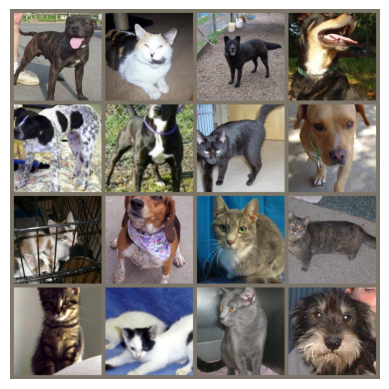

dogs           cats           dogs           dogs           
dogs           dogs           cats           dogs           
cats           dogs           cats           cats           
cats           cats           cats           dogs           


In [10]:
def show(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    plt.show()

def label_images(class_labels):
    for j in range(4):
        print("".join(f"{inv_map[x.item()]:15}" for x in class_labels[4*j:4*j+4]))

inputs, classes_ = next(iter(test_dataloader))
inputs = inputs[:16]
classes_ = classes_[:16]
out = torchvision.utils.make_grid(inputs, nrow=4, padding=10)
show(out)
label_images(classes_)

In [11]:
from torch import sigmoid
from torch import nn


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(p=0.5),
            nn.Flatten(),
            nn.Linear(40000, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1)
        )

    def forward(self, x):
        return self.cnn(x)

    def predict_proba(self, x):
        return sigmoid(self(x))

    def predict(self, x, threshold: float = 0.5):
        y_pred_score = self.predict_proba(x)
        return (y_pred_score > threshold).to(torch.int32)




In [31]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, roc_auc_score


def plot_precision_recall_curve(y_true, y_pred_score):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_score)
    disp = PrecisionRecallDisplay(precisions, recalls)
    disp.plot()
    plt.show()

def evaluate_model(model, dataloader):
    correct, auroc, total = 0, 0, 0
    model.eval()
    with torch.no_grad():
        total_predict = torch.tensor([])
        total_labels = torch.tensor([])
        for img, img_labels in dataloader:
            img_out = model.predict(img)
            total += img_labels.shape[0]
            correct += (torch.squeeze(img_out) == img_labels.int()).sum().item()
            predict = model.predict_proba(img)
            total_predict = torch.concat((total_predict, predict))
            total_labels = torch.concat((total_labels, img_labels))

    plot_precision_recall_curve(total_labels, total_predict)
    auroc = roc_auc_score(total_labels, total_predict)

    return {'AUROC' : auroc, 'correct': correct, 'total':total}

In [33]:
from torch import optim

EPOCHS = 5

model = CNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters())


for epoch in range(EPOCHS):
    model.train()
    print(f"EPOCH {epoch}")
    batch_loss = 0
    no_of_batches = 0
    for train_batch, y_batch in train_dataloader:
        y_pred = model(train_batch)
        loss = criterion(torch.squeeze(y_pred), y_batch.float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        batch_loss += loss.item()
        no_of_batches += 1
        if no_of_batches % 10 == 0:
            print(f"Batch number: {no_of_batches}")

    print(f"average batch loss = {batch_loss / no_of_batches}")
    print("========================")

EPOCH 0
Batch number: 10
Batch number: 20
Batch number: 30
Batch number: 40
Batch number: 50
Batch number: 60
Batch number: 70
Batch number: 80
Batch number: 90
Batch number: 100
Batch number: 110
Batch number: 120
Batch number: 130
Batch number: 140
Batch number: 150
Batch number: 160
Batch number: 170
Batch number: 180
Batch number: 190
Batch number: 200
Batch number: 210
Batch number: 220
Batch number: 230
Batch number: 240
Batch number: 250
average batch loss = 0.7098965526102073
EPOCH 1
Batch number: 10
Batch number: 20
Batch number: 30
Batch number: 40
Batch number: 50
Batch number: 60
Batch number: 70
Batch number: 80
Batch number: 90
Batch number: 100
Batch number: 110
Batch number: 120
Batch number: 130
Batch number: 140
Batch number: 150
Batch number: 160
Batch number: 170
Batch number: 180
Batch number: 190
Batch number: 200
Batch number: 210
Batch number: 220
Batch number: 230
Batch number: 240
Batch number: 250
average batch loss = 0.6360402281778267
EPOCH 2
Batch number: 

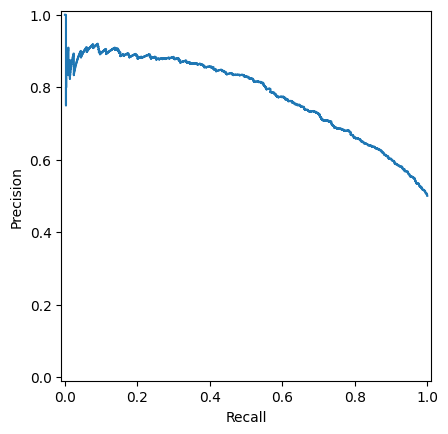

In [34]:
metrics = evaluate_model(model, test_dataloader)

In [35]:
print(metrics)

{'AUROC': 0.7853923051962015, 'correct': 1453, 'total': 2023}


In [39]:
torch.save(model.state_dict(), "saved_models/model_5_epochs.pth")

In [44]:
model = CNN()

In [46]:
model.load_state_dict(torch.load("saved_models/model_5_epochs.pth"))

<All keys matched successfully>

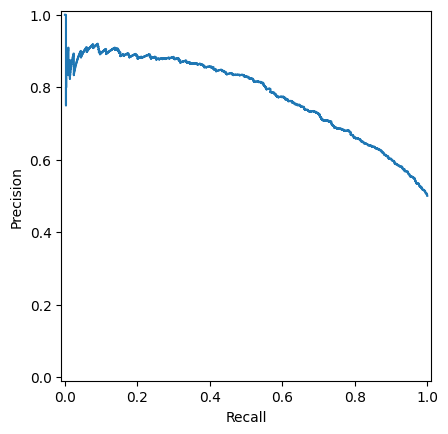

In [47]:
metrics = evaluate_model(model, test_dataloader)